### Import necessary dependencies

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import numpy as np
from tqdm import tqdm

### Configurations

In [2]:
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-4
num_epochs = 100
batch_size = 16
scale = 3
patch_size = (96, 96)
num_residual_blocks = 16

### Preprocessing

In [37]:
def image_to_patches(image, patch_size):
    channels, height, width = image.size()
    patch_height, patch_width = patch_size
    patches = []
    
    # Calculate padding needed for width and height
    pad_height = patch_height - height%patch_height
    pad_width = patch_width - width%patch_width
    
    # Apply the padding
    padded_image = F.pad(image, (0, pad_width, 0, pad_height))
    
    # start, stop, step
    for y in range(0, height, patch_height):
        for x in range(0, width, patch_width):
            # the patch consist of all the channels, 
            patch = padded_image[:, y:y+patch_height, x:x+patch_width]
            patches.append(patch)
            
            
    return patches
    

In [107]:
def preprocess_images_in_folder(folder_path, scale, patch_size):
    
    processed_images = []
    
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        
        input_image = cv2.imread(image_path)
        
        input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        
        # change cv2 BGR to RGB
        GT_tensor = torch.tensor(input_image_rgb, dtype=torch.float32).permute(2,0,1)/255
        
        
        GT_image_pil = Image.fromarray(input_image_rgb)
        LR_image = TF.resize(GT_image_pil, [GT_image_pil.size[1] // scale, GT_image_pil.size[0] // scale], interpolation=Image.BICUBIC)
        
        LR_tensor_resized = TF.resize(LR_image, [GT_tensor.shape[1], GT_tensor.shape[2]], interpolation=Image.BICUBIC)
        LR_tensor_resized = TF.to_tensor(LR_tensor_resized).float()
        
        LR_patches = image_to_patches(LR_tensor_resized, patch_size)
        GT_patches = image_to_patches(GT_tensor, patch_size)
        processed_images.extend(zip(LR_patches, GT_patches))
        
    return processed_images

In [7]:
def display_image(LR, GT):
    
    # Display Ground Truth Image
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(GT.permute(1,2,0))
    plt.title("Ground Truth (GT)")
    plt.axis('off')
    
    # Display the input image
    plt.subplot(1, 2, 1)
    plt.imshow(LR.permute(1, 2, 0))
    plt.title("Low Resolution (LR)")
    plt.axis('off')
    
    plt.show()
    

### Preprocessing training and test images

In [122]:
train_images_folder_path = 'data/Train/ILSVRC2013'
test_images_set5_folder_path = 'data/Test/Set5'
test_images_set14_folder_path = 'data/Test/Set14'

processed_train_images = preprocess_images_in_folder(train_images_folder_path, scale, patch_size)
processed_test_set5_images = preprocess_images_in_folder(test_images_set5_folder_path, scale, patch_size)
processed_test_set14_images = preprocess_images_in_folder(test_images_set14_folder_path, scale, patch_size)

torch.Size([3, 96, 96])


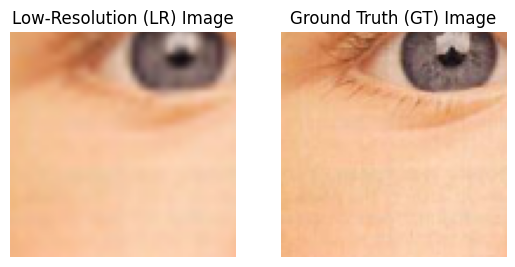

In [132]:
# Assuming processed_images is your list of LR and GT patches
random_pair = random.choice(processed_test_set5_images)
LR_patch, GT_patch = random_pair

# Plot LR image
plt.subplot(1, 2, 1)
plt.imshow(LR_patch.permute(1, 2, 0))  # Permute LR image dimensions to (height, width, channels) and plot
plt.title('Low-Resolution (LR) Image')
plt.axis('off')

print(LR_patch.size())
# Plot GT image
plt.subplot(1, 2, 2)
plt.imshow(GT_patch.permute(1, 2, 0))  # Assuming GT image is also in (height, width, channels) format
plt.title('Ground Truth (GT) Image')
plt.axis('off')

plt.show()

### Putting images in DataLoader

In [133]:
train_loader = DataLoader(processed_train_images, batch_size=batch_size)
test_set5_loader = DataLoader(processed_test_set5_images, batch_size=batch_size)
test_set14_loader = DataLoader(processed_test_set14_images, batch_size=batch_size)

### Defining Residual Block classes for Generator and Discriminator

In [134]:
class ResBlockGenerator(nn.Module):
    def __init__(self):
        super(ResBlockGenerator, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
        self.batch_norm1 = nn.BatchNorm2d(64, momentum=0.5)
        self.p_relu = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
        self.batch_norm2 = nn.BatchNorm2d(64, momentum=0.5)
        
    def forward(self, input_tensor):
        out = self.conv1(input_tensor)
        out = self.batch_norm1(out)
        out = self.p_relu(out)
        out = self.conv2(out)
        out = self.batch_norm2(out)
        out += input_tensor
        return out
        

### Defining Generator model

In [135]:
class Generator(nn.Module):
    def __init__(self, num_residual_blocks = num_residual_blocks):
        super(Generator, self).__init__()
        # Pre residual layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding='same')
        self.p_relu1 = nn.PReLU()
        
        self.residual_blocks = nn.Sequential(
            *[ResBlockGenerator() for _ in range(num_residual_blocks)]
        )
        
        # Post residual layers
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same')
        self.batch_norm = nn.BatchNorm2d(64, momentum=0.5)
        
        # Upsampling layers
        self.upsample1 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding='same'),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        
        self.upsample2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding='same'),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        
        # Output convolutional layer
        self.conv3 = nn.Conv2d(64, 3, kernel_size=9, stride=1, padding='same')
        
    def forward(self, input_tensor):
        out = self.conv1(input_tensor)
        out = self.p_relu1(out)
        input_residual_tensor = out.clone()
        
        for res_block in self.residual_blocks:
            out = res_block(out)
            
        out = self.conv2(out)
        out = self.batch_norm(out)
        out += input_residual_tensor
        
        out = self.upsample1(out)
        out = self.upsample2(out)
            
        out = self.conv3(out)
        return out
        

### Defining Discriminator model

In [136]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channel,out_channel, strides = 1 ):
        super(DiscriminatorBlock, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=strides, padding='same')
        self.batch_normalization = nn.BatchNorm2d(out_channel, momentum=0.8)
        self.leaky_relu = nn.LeakyReLU(0.2)
        
    def forward(self, input_tensor):
        out = self.conv(input_tensor)
        out = self.batch_normalization(out)
        out = self.leaky_relu(out)
        return out

In [137]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding='same')
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        
        self.block_with_batch_norm = nn.Sequential(
            DiscriminatorBlock(64, 64, strides=2),
            DiscriminatorBlock(64, 128),
            DiscriminatorBlock(128, 128,strides=2),
            DiscriminatorBlock(128, 256),
            DiscriminatorBlock(256, 256, strides=2),
            DiscriminatorBlock(256, 512, ),
            DiscriminatorBlock(512, 512, strides=2)
        )
        
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(512 * 4 * 4, 1024)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.dense2 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()
        
        
        
    def forward(self, input_tensor):
        out = self.conv1(input_tensor)
        out = self.leaky_relu1(out)
        out = self.block_with_batch_norm(out)
        out = self.flatten(out)
        out = self.dense1(out)
        out = self.leaky_relu2(out)
        out = self.dense2(out)
        out = self.sigmoid(out)
        return out
        

### Setting up loss functions

In [ ]:
adversarial_loss = nn.BCELoss()
#content_loss = nn.MSELoss()
optimizer = optim.Adam()

### Training Discriminator model

In [ ]:
discriminator_model = Discriminator()